# 필요한 모듈 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# 탐색

In [2]:
FILE_PATH = 'data/market-price.csv'
bitcoin_df = pd.read_csv(FILE_PATH, names=['day', 'price'])

In [3]:
bitcoin_df.shape

(365, 2)

In [4]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [5]:
bitcoin_df.head(3)

,day,price
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450


In [6]:
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head(3)

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450


In [7]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


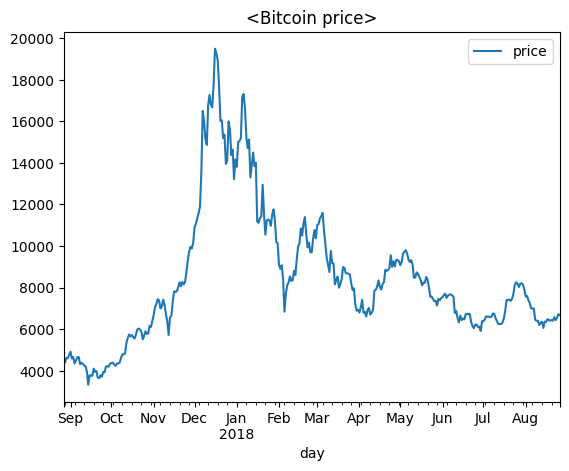

In [8]:
bitcoin_df.plot()
plt.title("<Bitcoin price>")
plt.show()

# 예측

In [9]:
def ADF_test(data):
	# ADF 실시
    results = adfuller(data, autolag='AIC')
    
    # 통계량
    s = results[0]
    # p-value
    p = results[1]
    # 기각역
    cv = results[4]
    
    # 출력
    print('-'*30)
    print('Augemented Dickey-Fuller Test')
    print('H0 : 단위근이 존재한다 (비정상 시계열)')
    print('Ha : 단위근이 없다 (정상 시계열)')
    print('Critical Values : {}'.format(cv))
    print('-'*30)
    print('Test Statistics : {:.4f}'.format(s))
    print('p-value : {:.4f}'.format(p))
    print('-'*30)

ADF_test(bitcoin_df)
# 귀무가설 기각 불가 : 단위근이 존재함. 비정상 시계열이다.

------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
------------------------------
Test Statistics : -1.7664
p-value : 0.3972
------------------------------


In [10]:
bitcoin_df_diff = bitcoin_df.diff().dropna()
# ADF 테스트
ADF_test(bitcoin_df_diff)

------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
------------------------------
Test Statistics : -5.3797
p-value : 0.0000
------------------------------


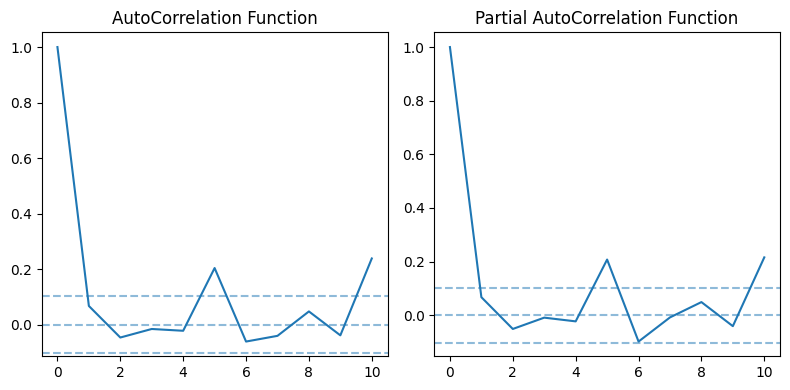

In [11]:
# ACF
acf_10 = acf(x=bitcoin_df_diff, nlags=10)
# PACF
pacf_10 = pacf(x=bitcoin_df_diff, nlags=10, method='ols')

# 95% 신뢰구간 계산하기
confidence = 1.96/np.sqrt(len(bitcoin_df_diff))

# 시각화
plt.figure(figsize=(8,4))
# ACF
plt.subplot(1,2,1)
plt.plot(acf_10)
plt.axhline(y=0, linestyle='--', alpha=0.5)
plt.axhline(y=-confidence, linestyle='--', alpha=0.5)
plt.axhline(y=confidence, linestyle='--', alpha=0.5)
plt.title('AutoCorrelation Function')

# PACF
plt.subplot(1,2,2)
plt.plot(pacf_10)
plt.axhline(y=0, linestyle='--', alpha=0.5)
plt.axhline(y=-confidence, linestyle='--', alpha=0.5)
plt.axhline(y=confidence, linestyle='--', alpha=0.5)
plt.title('Partial AutoCorrelation Function')

plt.tight_layout()

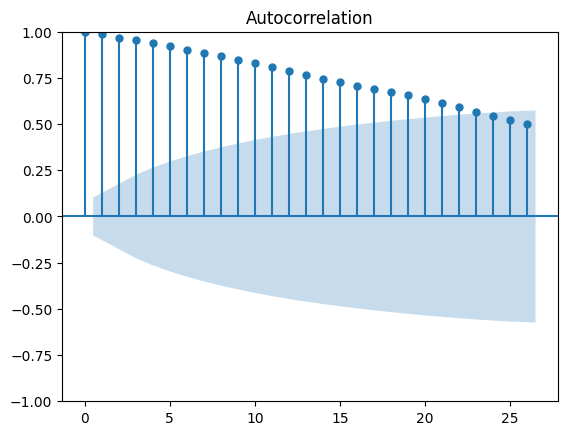

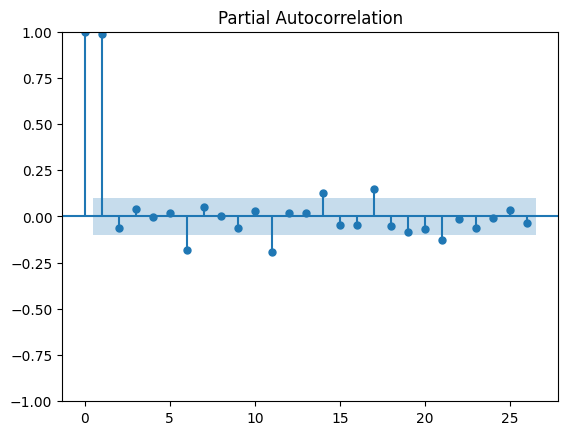

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()

In [13]:
# index를 period로 변환해주어야 warning이 뜨지 않음
bitcoin_df_copy = bitcoin_df.copy()
bitcoin_df_copy.index = pd.DatetimeIndex(bitcoin_df_copy.index).to_period('D')

# 예측을 시작할 위치(차분을 적용하기 때문에 맞추어준다.)
start_idx = bitcoin_df_copy.index[1]

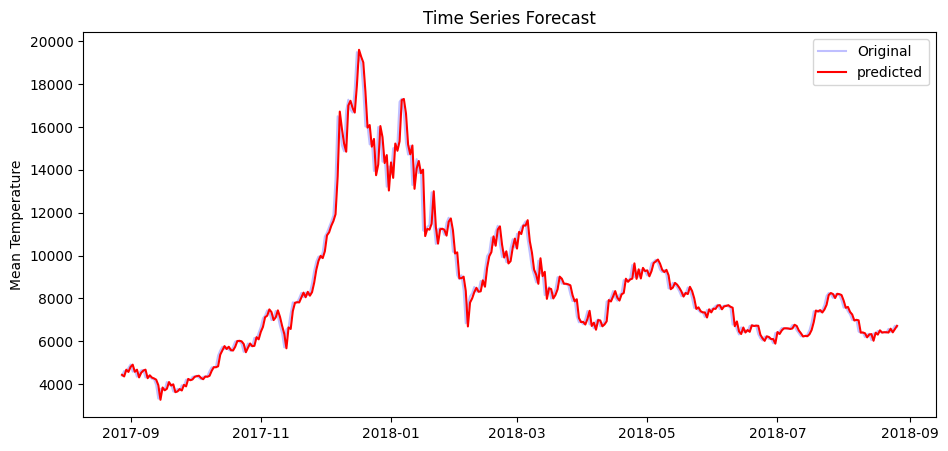

Mean Squared Error : 512.3291


In [14]:
def plot_and_error(data, forecast):
    # MSE 계산
    mse = mean_squared_error(data, forecast) ** 0.5
    # 시각화
    plt.figure(figsize=(11,5))
    plt.plot(data, color='blue', alpha=0.25 , label='Original')
    plt.plot(forecast, color='red', label='predicted')
    plt.title("Time Series Forecast")
    plt.ylabel("Mean Temperature")
    plt.legend()
    plt.show()
    # MSE 출력
    print('Mean Squared Error : {:.4f}'.format(mse))

# ARIMA(2,1,2)
model = ARIMA(bitcoin_df_copy, order=(2,1,2))
# fit model
model_fit = model.fit()

# 전체에 대한 예측 실시
forecast1 = model_fit.predict(start=start_idx)
plot_and_error(bitcoin_df[1:], forecast1)

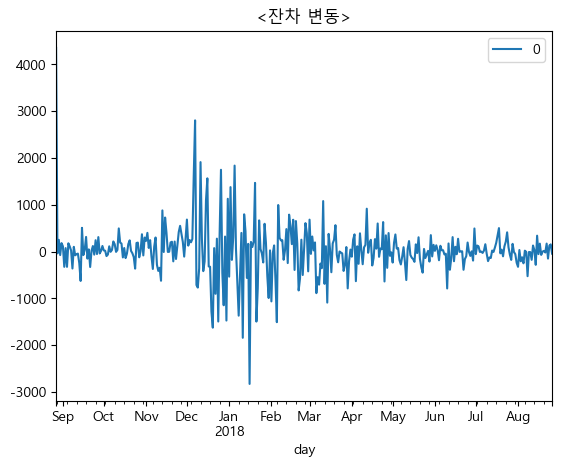

In [15]:
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
residuals = pd.DataFrame(model_fit.resid) # 잔차 변동을 시각화
residuals.plot()
plt.title("<잔차 변동>")
plt.show()

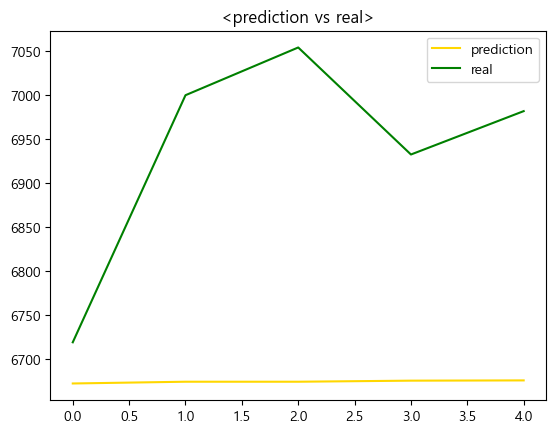

In [16]:
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
test_file_path = 'data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)

plt.plot(pred_y, color='gold', label="prediction")
plt.plot(test_y, color='green', label="real")
plt.legend()
plt.title("<prediction vs real>")
plt.show()

# Facebook Prophet 활용하기

- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미. 비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋다.
- changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측한다. 수치가 높을수록 overfitting에 가까워진다.

In [17]:
from prophet import Prophet

FILE_PATH = 'data/market-price.csv'

bitcoin_df = pd.read_csv(FILE_PATH, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

Importing plotly failed. Interactive plots will not work.
20:08:42 - cmdstanpy - INFO - Chain [1] start processing
20:08:43 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# 5일을 내다보며 예측.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [19]:
forecast_data.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-08-27,480.962323,3758.572228,5115.554630,480.962323,480.962323,9.32504,9.32504,9.32504,8.222356,...,-0.039845,-0.039845,-0.039845,-1.062839,-1.062839,-1.062839,0.0,0.0,0.0,4435.605917
1,2017-08-28,483.577026,3872.682502,5144.861592,483.577026,483.577026,9.32504,9.32504,9.32504,8.313077,...,-0.007087,-0.007087,-0.007087,-1.004876,-1.004876,-1.004876,0.0,0.0,0.0,4503.590273
2,2017-08-29,486.191730,3880.876011,5243.995254,486.191730,486.191730,9.32504,9.32504,9.32504,8.380058,...,0.017472,0.017472,0.017472,-0.962454,-0.962454,-0.962454,0.0,0.0,0.0,4560.506475
3,2017-08-30,488.806434,3885.224216,5235.853658,488.806434,488.806434,9.32504,9.32504,9.32504,8.344389,...,-0.042036,-0.042036,-0.042036,-0.938615,-0.938615,-0.938615,0.0,0.0,0.0,4567.597547
4,2017-08-31,491.421138,3948.128415,5253.785647,491.421138,491.421138,9.32504,9.32504,9.32504,8.376583,...,-0.012621,-0.012621,-0.012621,-0.935836,-0.935836,-0.935836,0.0,0.0,0.0,4607.851310


In [20]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6978.697763,6293.693689,7586.100322
366,2018-08-28,7082.561527,6392.676229,7701.377257
367,2018-08-29,7111.709229,6441.478953,7803.861693
368,2018-08-30,7195.310702,6431.062027,7982.752391
369,2018-08-31,7278.045865,6520.467497,8041.069167


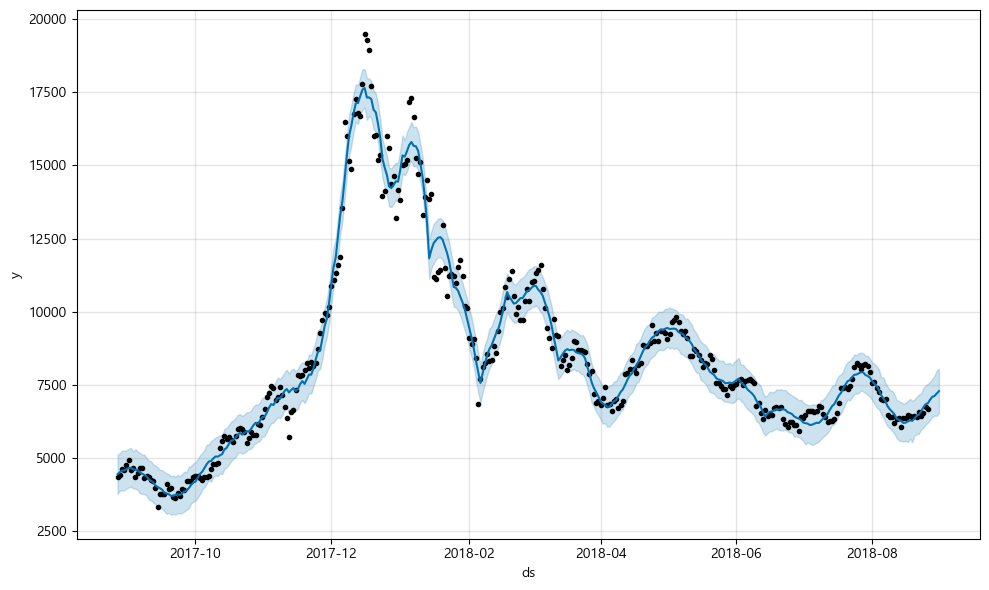

In [21]:
fig1 = prophet.plot(forecast_data)
# 검은 점은 실제 가격, 파란 선은 예측 가격

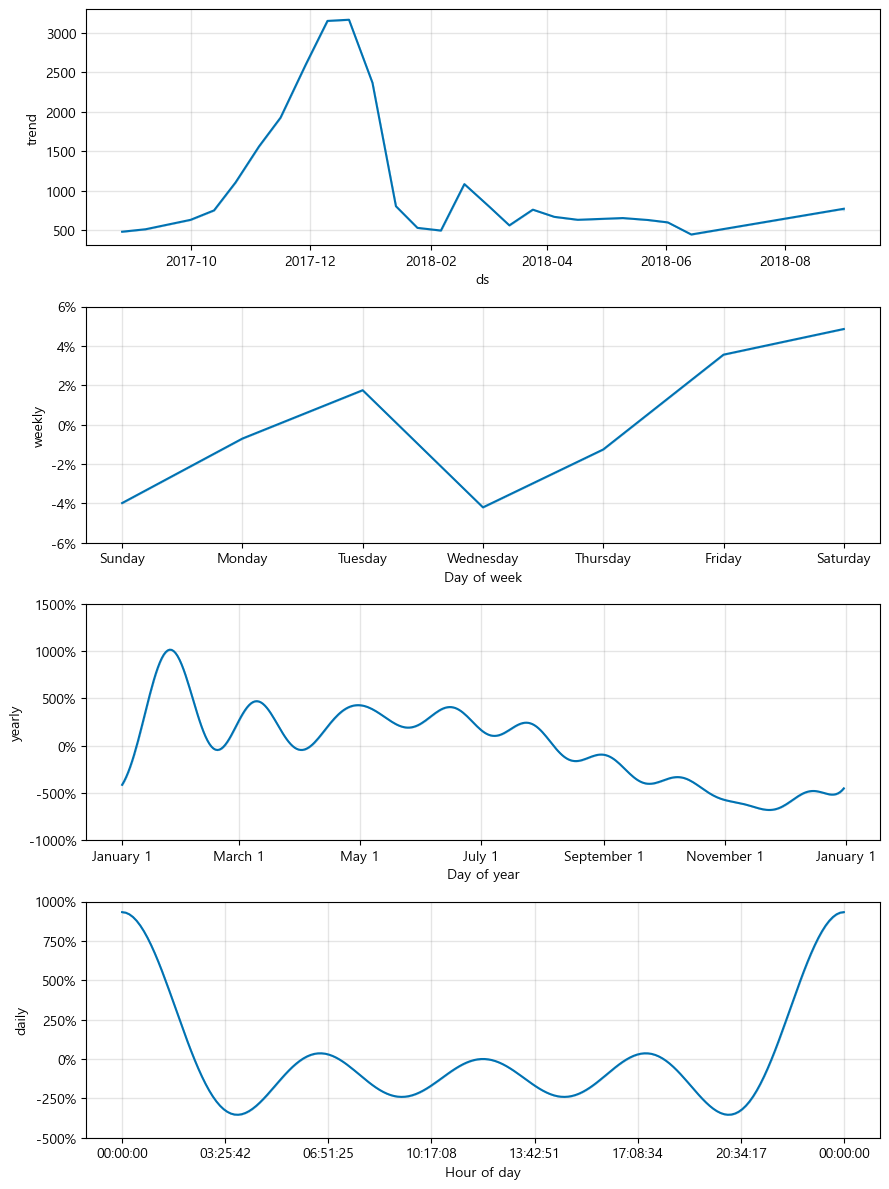

In [22]:
# 트렌드 정보 시각화
fig2 = prophet.plot_components(forecast_data)

In [23]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터.
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터.

In [24]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

521.9045082616989
0.9738173522752884


In [25]:
test_file_path = 'data/market-price-test.csv'

bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 마지막 5일의 예측 데이터
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값.

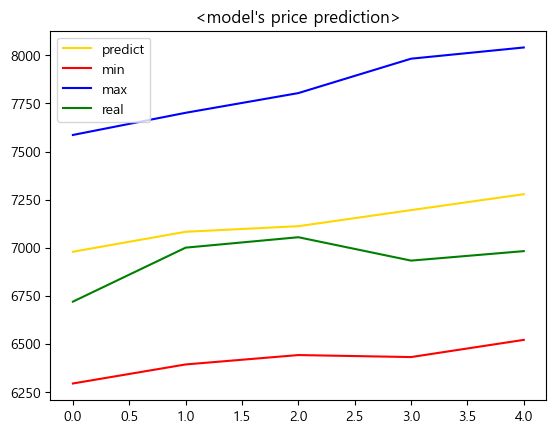

In [26]:
plt.plot(pred_y, color="gold", label='predict') # 모델이 예상한 가격 그래프.
plt.plot(pred_y_lower, color="red", label='min') # 모델이 예상한 최소가격 그래프.
plt.plot(pred_y_upper, color="blue", label='max') # 모델이 예상한 최대가격 그래프.
plt.plot(test_y, color="green", label='real') # 실제 가격 그래프.
plt.legend()
plt.title("<model's price prediction>")
plt.show()

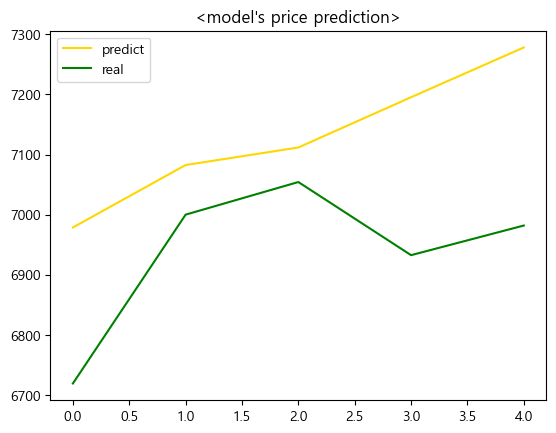

In [27]:
plt.plot(pred_y, color="gold", label='predict') # 모델이 예상한 가격 그래프.
plt.plot(test_y, color="green", label='real') # 실제 가격 그래프.
plt.legend()
plt.title("<model's price prediction>")
plt.show()

In [28]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

216.36645103460737


# 예측력 향상시키기

## 상한가 설정

In [29]:
bitcoin_df = pd.read_csv(FILE_PATH, names=['ds', 'y'])

# 상한가를 설정
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 설정
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic', # 앞서와 다르게 추가된 부분
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

20:08:45 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# 5일을 내다보며 예측.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

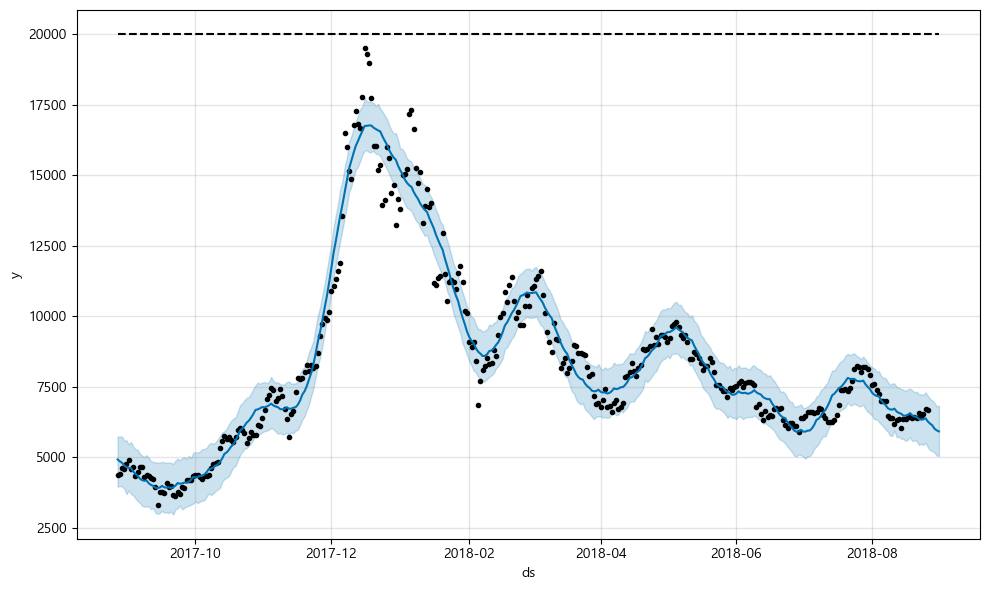

In [31]:
fig = prophet.plot(forecast_data)

In [32]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터.
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터.

rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

690.4605313428115
0.9541742921431307


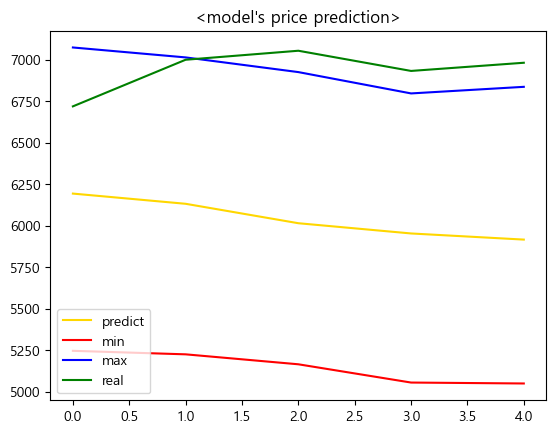

In [33]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져온다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold", label='predict') # 모델이 예상한 가격 그래프.
plt.plot(pred_y_lower, color="red", label='min') # 모델이 예상한 최소가격 그래프.
plt.plot(pred_y_upper, color="blue", label='max') # 모델이 예상한 최대가격 그래프.
plt.plot(test_y, color="green", label='real') # 실제 가격 그래프.
plt.legend()
plt.title("<model's price prediction>")
plt.show()

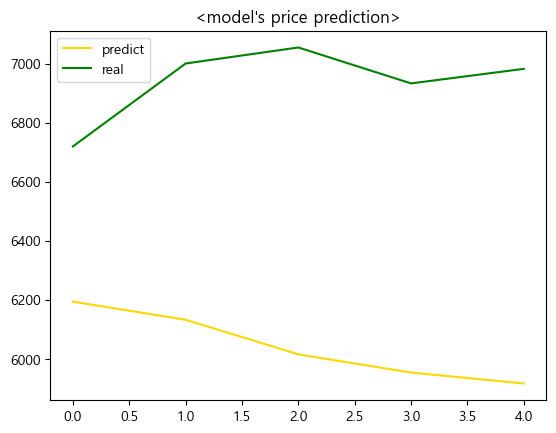

In [34]:
plt.plot(pred_y, color="gold", label='predict') # 모델이 예상한 가격 그래프.
plt.plot(test_y, color="green", label='real') # 실제 가격 그래프.
plt.legend()
plt.title("<model's price prediction>")
plt.show()

In [35]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)
# 성능이 더 안 좋아졌다.

916.5468395957115


## 이상치 제거

In [36]:
# 18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(FILE_PATH, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

20:08:47 - cmdstanpy - INFO - Chain [1] start processing
20:08:48 - cmdstanpy - INFO - Chain [1] done processing


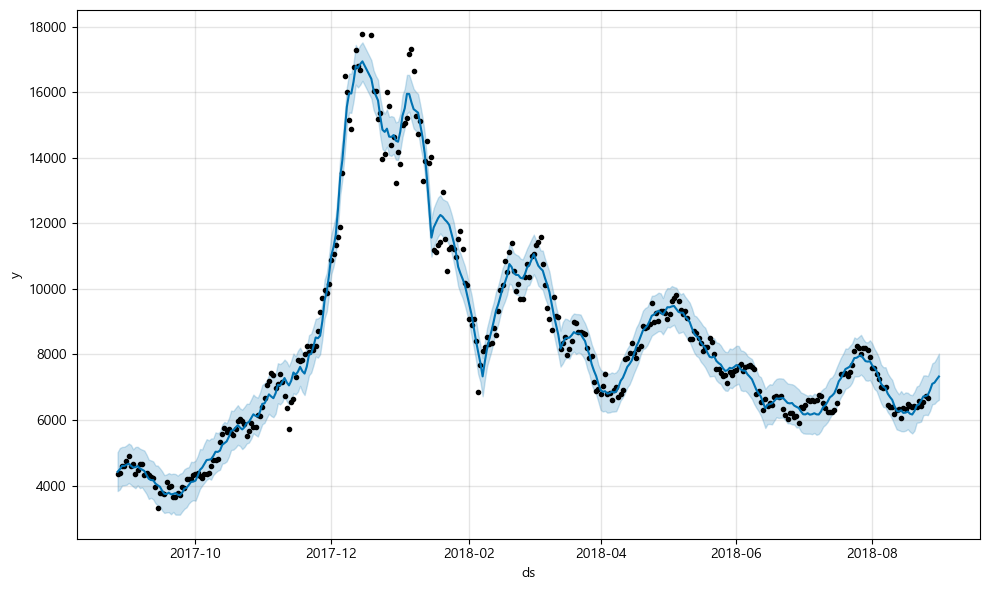

In [37]:
# prophet 모델을 학습
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력.
fig = prophet.plot(forecast_data)

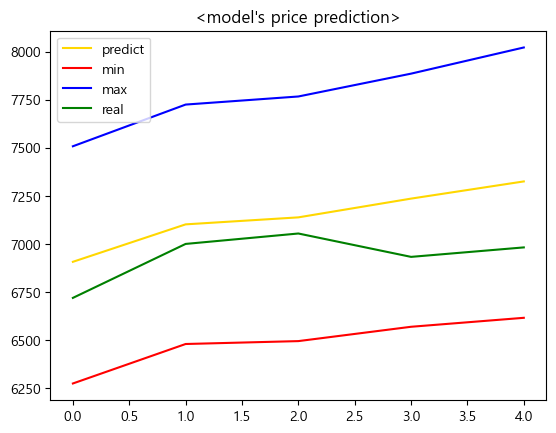

In [39]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold", label='predict') # 모델이 예상한 가격 그래프.
plt.plot(pred_y_lower, color="red", label='min') # 모델이 예상한 최소가격 그래프.
plt.plot(pred_y_upper, color="blue", label='max') # 모델이 예상한 최대가격 그래프.
plt.plot(test_y, color="green", label='real') # 실제 가격 그래프.
plt.legend()
plt.title("<model's price prediction>")
plt.show()

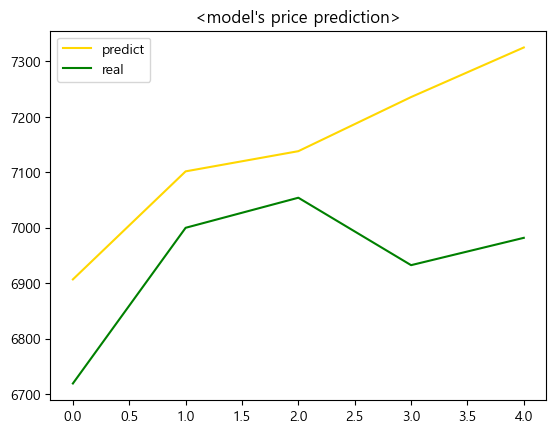

In [40]:
plt.plot(pred_y, color="gold", label='predict') # 모델이 예상한 가격 그래프.
plt.plot(test_y, color="green", label='real') # 실제 가격 그래프.
plt.legend()
plt.title("<model's price prediction>")
plt.show()

In [41]:
# 테스트 데이터의 RMSE를 출력.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

229.09551014374406


### 예측력 향상 실패